In [1]:
import numpy as np
import pandas as pd
import math
import itertools as itt
import collections as clc
import networkx as nx

from matplotlib import pyplot as plt

from utils import *

path_data = '/Users/dariozappala/Library/CloudStorage/Dropbox/università/RTD-A/progetti/dati/Crunchbase/'
path_images = './immagini/'

__df_organizations__: dati sulle compagnie\
__df_organizations_time__: solo compagnie fondate a partire da 'year_start_company'

__df_money__: dati sui soldi ricevuti\
__df_money_sel__: solo operazioni a partire da 'year_start_operations', solo compagnie fondate a partire da 'year_start_company', solo città selezionate da 'df_stats_sel'

__df_stats_sel__: solo città con n. d'operazioni pari almeno a 'threshold_operations'

__df_evolution__, __ser_network__: sono calcolate a partire da 'df_organizations_time'

__ser_pagerank_allnodes__: a partire da 'year_start_analysis'

__df_money_ecosystems__: soldi ricevuti da ciascuna città selezionata ('df_stats_sel'), per gruppi d'anni, calcolati a partire da 'df_money_sel'\
__df_n_companies_ecosystems__: compagnie presenti in ciascuna città selezionata ('df_stats_sel'), per gruppi d'anni, calcolate a partire da 'df_organizations_time'

# Lettura

In [2]:
%%time
df_organizations = pd.read_csv(path_data + 'organizations.csv')
clean_organizations(df_organizations)

# Select companies with declared market sectors and foundation year
df_organizations = df_organizations.loc[
    (~df_organizations['category_list'].isna()) & (~df_organizations['founded_on'].isna()),
    ['uuid', 'founded_on', 'name', 'country_code', 'city', 'category_list']
]

# Only keep year of foundation
df_organizations['founded_on'] = df_organizations['founded_on'].dt.year

# Transform market sectors from one big string to a list of strings
df_organizations['sectors'] = df_organizations['category_list'].str.split(',')
df_organizations.drop(columns = 'category_list', inplace = True)

df_organizations.sort_values(['founded_on', 'name'], inplace = True)
df_organizations.reset_index(drop = True, inplace = True)

print(df_organizations.shape)
display(df_organizations.head())

(2411666, 6)


,uuid,founded_on,name,country_code,city,sectors
0,82669160-969a-92da-eb44-3ef775925ed8,1678,Mitsubishi Tanabe Pharma,JPN,Osaka,"[Biotechnology, Pharmaceutical]"
1,86caf27a-cf0a-4ca5-8baf-c55b9438f3f1,1678,Strelley Hall,GBR,Nottingham,"[Customer Service, Real Estate, Rental Propert..."
2,49cc78d1-8541-44d1-ae0f-055d2b1543ac,1678,Tigges,DEU,Oelde,"[Foundries, Industrial, Machinery Manufacturing]"
3,beb84b4b-7908-43ab-92f4-84214d43e438,1678,Vittoria Health Nutrition,ITA,Roreto,"[Confectionery, Food and Beverage, Manufacturi..."
4,8dbe61b8-7800-43dd-b420-621b3703f799,1679,Eichbaum,DEU,Mannheim,"[Brewing, Food and Beverage, Food Processing]"


CPU times: user 33 s, sys: 7.53 s, total: 40.5 s
Wall time: 43.9 s


In [3]:
%%time
df_money = pd.concat((
    pd.read_csv(path_data + 'acquisitions.csv')[['acquired_on', 'type', 'acquiree_uuid', 'price_usd']]
        .rename(columns = {'acquired_on': 'time', 'acquiree_uuid': 'org_uuid', 'price_usd': 'money_usd'}),
    pd.read_csv(path_data + 'ipos.csv')[['went_public_on', 'type', 'org_uuid', 'money_raised_usd']]
        .assign(type = 'IPO')
        .rename(columns = {'went_public_on': 'time', 'money_raised_usd': 'money_usd'})
))
df_money = df_money.loc[~df_money['money_usd'].isna()]
df_money['time'] = pd.to_datetime(df_money['time'], errors = 'coerce')
df_money = df_money.loc[~df_money['time'].isna()]
df_money['time'] = df_money['time'].dt.year

df_money = pd.merge(
    df_money, df_organizations,
    left_on = 'org_uuid', right_on = 'uuid',
    how = 'inner'
).drop(columns = ['org_uuid', 'sectors']).rename(columns = {'uuid': 'org_uuid'})

df_money = df_money.loc[df_money['founded_on'] <= df_money['time']]

df_money.sort_values(['time', 'name'], inplace = True)
df_money.reset_index(drop = True, inplace = True)

print(df_money.shape)
display(df_money.head())

(29670, 8)


,time,type,money_usd,org_uuid,founded_on,name,country_code,city
0,1909,acquisition,4500000.0,d5140c56-2123-dec2-97b8-35f7b946a061,1908,Cadillac,USA,Detroit
1,1922,acquisition,8000000.0,bbcaa5a1-a748-07d2-f1fe-72a57acbf31c,1917,Lincoln Motor Company,USA,Dearborn
2,1950,IPO,679070.0,aafb7e4f-44fe-54ed-12ba-12cef41d717c,1890,Adcock Ingram Healthcare,IND,Banswada
3,1961,IPO,3800000.0,08ac1ba9-6ec5-82a5-5028-9dac1db7c42d,1950,Murphy Oil Corporation,USA,Plainview
4,1967,acquisition,8000000.0,eec9d08c-339d-e254-d107-39106ecf30e9,1919,Ringling Brothers Barnum and Bailey Circus,USA,Palmetto


CPU times: user 2.23 s, sys: 154 ms, total: 2.38 s
Wall time: 2.41 s


# Selezione
Solo compagnie fondate a partire da un certo anno.\
Solo operazioni finanziarie (offerte pubbliche iniziali + acquisizioni) a partire da un certo anno.\
Solo città con un certo numero d'operazioni finanziarie.

Selected cities: 36


,country_code,city,operations
0,GBR,London,970
1,USA,New York,823
2,USA,San Francisco,578
3,CHN,Beijing,317
4,USA,Houston,274


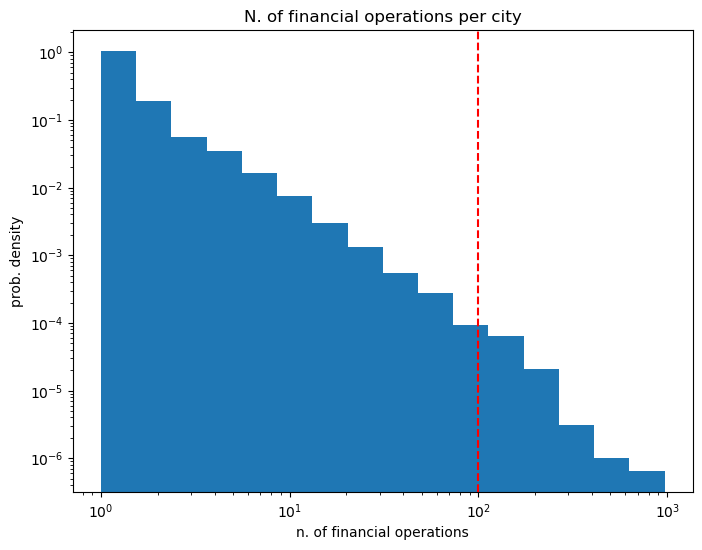

Table of selected operations: (7953, 8)


,time,type,money_usd,org_uuid,founded_on,name,country_code,city
0,1976,acquisition,28000000.0,17fc007e-1f5d-3ff8-8f03-bcff5c9528a5,1972,Atari,USA,New York
1,1978,IPO,6500000.0,2fc47cc7-c5ec-ea90-7a89-2cbdd8c316ae,1971,Southwest Airlines,USA,Dallas
2,1981,IPO,3200000.0,e5ff3e1d-3868-b687-514b-6e6d45ba07d1,1976,CA Technologies,USA,New York
3,1981,IPO,15000000.0,ca0dc3f8-5f97-fded-6e0e-14c53d5302d6,1978,The Home Depot,USA,Atlanta
4,1983,IPO,67000000.0,10a3b2fd-b142-046b-7d8f-3b1aa4877aca,1982,Compaq,USA,Palo Alto


In [4]:
year_start_company = 1970   # Consider only companies founded from that year on
year_start_operations = 1970   # Consider only operations from that year on
threshold_operations = 100   # Consider only cities with at least this n. of operations
year_start_analysis = year_start_operations
years_step = 5

###

df_organizations_time = df_organizations.loc[df_organizations['founded_on'] >= year_start_company]
list_years_step = list(range(year_start_analysis, df_organizations_time['founded_on'].max() + 1, years_step))
df_money_sel = df_money.loc[(df_money['time'] >= year_start_operations) & (df_money['founded_on'] >= year_start_company)]

df_stats = (
    df_money_sel
    .assign(operations = 1)
    .groupby(['country_code', 'city'])[['operations']].sum()
    .sort_values('operations', ascending = False)
    .reset_index()
)

#display(df_stats.head(10))

df_stats_sel = df_stats.loc[df_stats['operations'] >= threshold_operations].reset_index(drop = True)
print(f'Selected cities: {df_stats_sel.shape[0]}')
display(df_stats_sel.head())

df_money_sel = pd.merge(
    df_stats_sel, df_money_sel, on = ('country_code', 'city'), how = 'inner'
)[df_money_sel.columns].sort_values(['time', 'name']).reset_index(drop = True)

###

ser_data = df_stats['operations']
n_bins = math.floor(1/4 * pow(ser_data.shape[0], 1/2))
bins = np.logspace(np.log10(ser_data.min()), np.log10(ser_data.max()), n_bins + 1)

fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(ser_data, bins = bins, density = True)
ax.axvline(x = threshold_operations, ls = 'dashed', c = 'red')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('n. of financial operations')
ax.set_ylabel('prob. density')
ax.set_title('N. of financial operations per city')
plt.show()

###

#display(df_stats_sel.assign(count = 1).groupby('country_code')[['count']].sum())

print(f'Table of selected operations: {df_money_sel.shape}')
display(df_money_sel.head())

# Computations

Compute the series of the total network at each time

In [16]:
# How many years in the past to take data when building network of current year. If 0, only data of current year is used; if None, data of all years is used.
years_past_net_build = None

In [17]:
%%time
df_evolution, ser_network = compute_evolution(df_organizations_time, years_past = years_past_net_build)
df_evolution.head()

CPU times: user 15.1 s, sys: 505 ms, total: 15.6 s
Wall time: 15.7 s


,sectors,links
1970,"{'Property Development': 94, 'Property Managem...","{('Property Development', 'Property Management..."
1971,"{'Building Maintenance': 87, 'Construction': 5...","{('Building Maintenance', 'Construction'): 45,..."
1972,"{'Computer': 50, 'Software': 245, 'Tourism': 7...","{('Computer', 'Software'): 23, ('Tourism', 'Tr..."
1973,"{'Accounting': 175, 'Financial Services': 582,...","{('Accounting', 'Financial Services'): 138, ('..."
1974,"{'Farming': 37, 'Landscaping': 50, 'Non Profit...","{('Farming', 'Landscaping'): 2, ('Farming', 'N..."


In [18]:
# Money received by each selected ecosystem, for each period
df_money_ecosystems = (
    df_money_sel
    .groupby(
        ['country_code', 'city', pd.cut(df_money_sel['time'], bins = list_years_step)],
        observed = True
    )[['money_usd']].sum()
    .reset_index()
)
df_money_ecosystems['time'] = df_money_ecosystems['time'].apply(lambda x: x.left)
df_money_ecosystems.rename(columns = {'time': 'year', 'money_usd': 'money_following_period'}, inplace = True)

df_money_ecosystems

,country_code,city,year,money_following_period
0,AUS,Melbourne,1995,1.182383e+09
1,AUS,Melbourne,2005,9.382364e+08
2,AUS,Melbourne,2010,1.710683e+10
3,AUS,Melbourne,2015,1.566086e+10
4,AUS,Sydney,1995,6.000000e+07
...,...,...,...,...
192,USA,Waltham,1995,2.011700e+09
193,USA,Waltham,2000,1.495850e+09
194,USA,Waltham,2005,3.855500e+09
195,USA,Waltham,2010,1.273700e+10


In [19]:
# N. of companies in each selected ecosystem, for each period
df_n_companies_ecosystems = (
    pd.merge(df_stats_sel, df_organizations_time, on = ('country_code', 'city'), how = 'inner')
    .assign(companies = 1)
    .groupby(['country_code', 'city', 'founded_on'])[['companies']].sum()
    .reset_index()
)
df_n_companies_ecosystems['companies_cumul'] = df_n_companies_ecosystems.groupby(['country_code', 'city'])['companies'].cumsum()
df_n_companies_ecosystems = (
    df_n_companies_ecosystems
    .groupby(
        ['country_code', 'city', pd.cut(df_n_companies_ecosystems['founded_on'], bins = [0] + list_years_step[:-1])],
        observed = True
    )[['companies_cumul']].max()
    .reset_index()
)
df_n_companies_ecosystems['founded_on'] = df_n_companies_ecosystems['founded_on'].apply(lambda x: x.right)
df_n_companies_ecosystems.reset_index(drop = True, inplace = True)
df_n_companies_ecosystems.rename(columns = {'founded_on': 'year'}, inplace = True)

df_n_companies_ecosystems

,country_code,city,year,companies_cumul
0,AUS,Melbourne,1970,18
1,AUS,Melbourne,1975,100
2,AUS,Melbourne,1980,205
3,AUS,Melbourne,1985,379
4,AUS,Melbourne,1990,631
...,...,...,...,...
353,USA,Waltham,1995,204
354,USA,Waltham,2000,371
355,USA,Waltham,2005,496
356,USA,Waltham,2010,631


In [20]:
# Table with all information for each selected ecosystem, for each period
df_ecosystems = pd.merge(
    df_money_ecosystems,
    df_n_companies_ecosystems,
    on = ['country_code', 'city', 'year'], how = 'outer', sort = True
)
df_ecosystems['money_following_period'] = df_ecosystems['money_following_period'].fillna(0)

df_ecosystems

,country_code,city,year,money_following_period,companies_cumul
0,AUS,Melbourne,1970,0.000000e+00,18
1,AUS,Melbourne,1975,0.000000e+00,100
2,AUS,Melbourne,1980,0.000000e+00,205
3,AUS,Melbourne,1985,0.000000e+00,379
4,AUS,Melbourne,1990,0.000000e+00,631
...,...,...,...,...,...
353,USA,Waltham,1995,2.011700e+09,204
354,USA,Waltham,2000,1.495850e+09,371
355,USA,Waltham,2005,3.855500e+09,496
356,USA,Waltham,2010,1.273700e+10,631


Compute the series of Page Rank of the whole network

In [21]:
ser_pagerank_allnodes = pd.Series(index = list_years_step, dtype = object)
for idx in ser_pagerank_allnodes.index:
    net = ser_network[idx]
    if (net):
        ser_pagerank_allnodes[idx] = nx.pagerank(net, weight = None)
    else:
        ser_pagerank_allnodes[idx] = np.nan

Write in the table the values of Page Rank of the ecosystem for all times

In [22]:
%%time

df_ecosystems['centrality'] = np.nan

for i in range(df_stats_sel.shape[0]):
    country = df_stats_sel.loc[i, 'country_code']
    city = df_stats_sel.loc[i, 'city']
    
    # Compute the series of sectors of the ecosystem
    ser_sectors_sub = compute_evolution_sectors(
        df_organizations_time,
        (df_organizations['country_code'] == country) & (df_organizations['city'] == city)
    )
    
    # Write in the table the values of Page Rank of the ecosystem for all times
    df_ecosystems.loc[(df_ecosystems['country_code'] == country) & (df_ecosystems['city'] == city), 'centrality'] = list(
        sum(ser_pagerank_allnodes[idx][key] for key in ser_sectors_sub[idx])
        for idx in df_ecosystems.loc[(df_ecosystems['country_code'] == country) & (df_ecosystems['city'] == city), 'year']
    )

df_ecosystems

CPU times: user 12.8 s, sys: 356 ms, total: 13.1 s
Wall time: 13.2 s


,country_code,city,year,money_following_period,companies_cumul,centrality
0,AUS,Melbourne,1970,0.000000e+00,18,0.195709
1,AUS,Melbourne,1975,0.000000e+00,100,0.432146
2,AUS,Melbourne,1980,0.000000e+00,205,0.506747
3,AUS,Melbourne,1985,0.000000e+00,379,0.615137
4,AUS,Melbourne,1990,0.000000e+00,631,0.665955
...,...,...,...,...,...,...
353,USA,Waltham,1995,2.011700e+09,204,0.431677
354,USA,Waltham,2000,1.495850e+09,371,0.557391
355,USA,Waltham,2005,3.855500e+09,496,0.607738
356,USA,Waltham,2010,1.273700e+10,631,0.635510


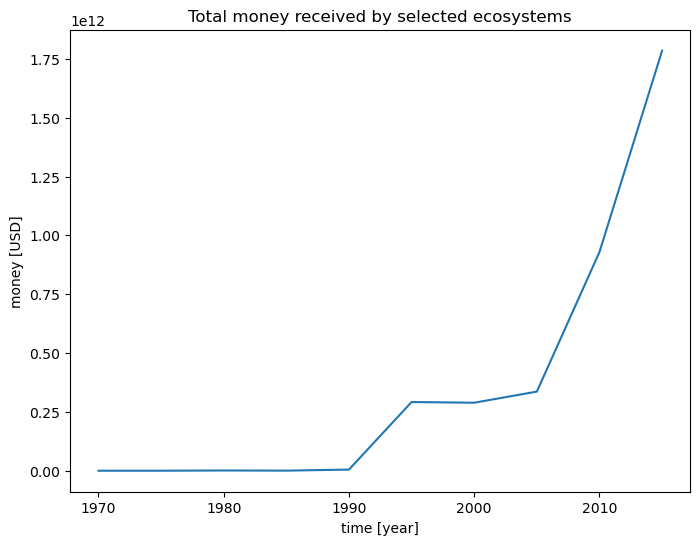

In [23]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(df_ecosystems.groupby('year', observed = True)['money_following_period'].sum())
#ax.set_yscale('log')
ax.set_xlabel('time [year]')
ax.set_ylabel('money [USD]')
ax.set_title('Total money received by selected ecosystems')
plt.show()

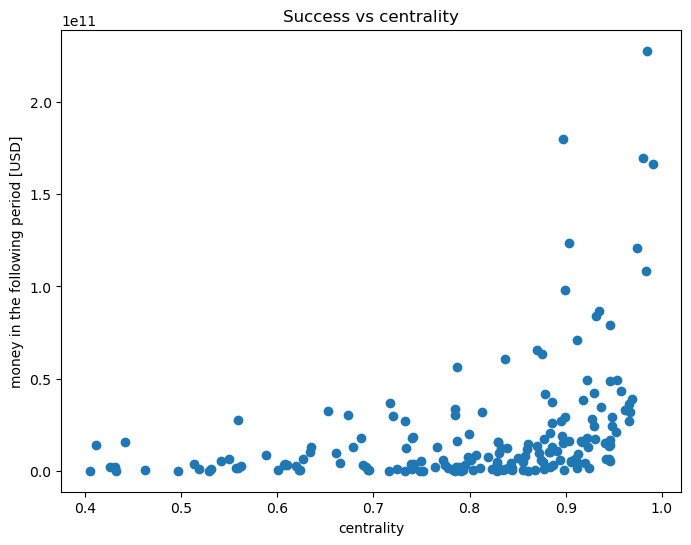

In [29]:
data = df_ecosystems[df_ecosystems['year'] > 1990]

fig, ax = plt.subplots(figsize = (8, 6))
ax.scatter(data['centrality'], data['money_following_period'])
ax.set_xlabel('centrality')
ax.set_ylabel('money in the following period [USD]')
ax.set_title('Success vs centrality')
plt.show()